In [ ]:
!pip install kaggle
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
with open("/root/.kaggle/kaggle.json", "w+") as f: f.write('{"username":"","key":""}')
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hojjatk/mnist-dataset
!unzip mnist-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
mnist-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  mnist-dataset.zip
replace t10k-images-idx3-ubyte/t10k-images-idx3-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: t10k-images.idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: t10k-labels.idx1-ubyte  
  inflating: train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: train-images.idx3-ubyte  
  inflating: train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: train-labels.idx1-ubyte  


In [ ]:
import numpy as np
import struct
from array import array
from os.path import join
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28 , 28)
            images.append(img)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

input_path = '/content/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNISTDataset(x_train, y_train, transform=transform)
test_dataset = MNISTDataset(x_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

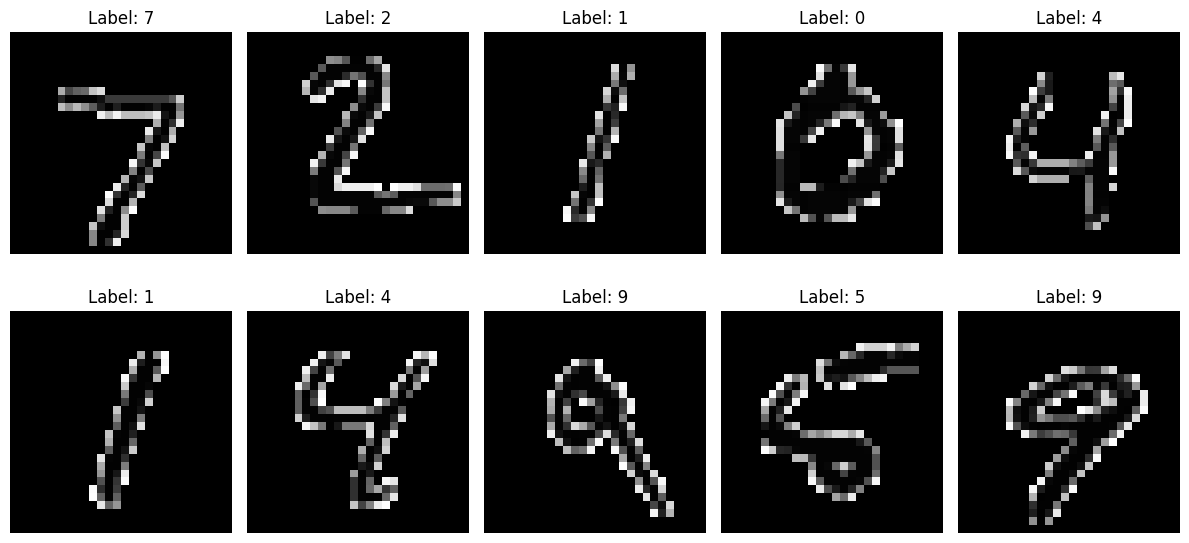

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Display the top 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # 2 rows and 5 columns for a total of 10 images
axes = axes.flatten()

for i in range(10):
    image = images[i][0]  # Get the ith image
    label = labels[i].item()  # Get the ith label

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    loss_values = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Plotting the loss over epochs
    plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(images)
            train_loss = criterion(outputs, labels)

            train_loss.backward()
            optimizer.step()

            running_train_loss += train_loss.item()

        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                test_loss = criterion(outputs, labels)
                running_test_loss += test_loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_losses.append(running_test_loss / len(test_loader))
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, accuracies


Epoch [1/20], Train Loss: 1.0094, Test Loss: 0.6797, Accuracy: 77.78%
Epoch [2/20], Train Loss: 0.6434, Test Loss: 0.6257, Accuracy: 79.57%
Epoch [3/20], Train Loss: 0.5354, Test Loss: 0.5129, Accuracy: 83.20%
Epoch [4/20], Train Loss: 0.4842, Test Loss: 0.4808, Accuracy: 84.70%
Epoch [5/20], Train Loss: 0.4370, Test Loss: 0.4301, Accuracy: 86.25%
Epoch [6/20], Train Loss: 0.4002, Test Loss: 0.4303, Accuracy: 86.28%
Epoch [7/20], Train Loss: 0.3674, Test Loss: 0.4365, Accuracy: 86.28%
Epoch [8/20], Train Loss: 0.3467, Test Loss: 0.3884, Accuracy: 87.45%
Epoch [9/20], Train Loss: 0.3274, Test Loss: 0.3798, Accuracy: 88.42%
Epoch [10/20], Train Loss: 0.3053, Test Loss: 0.3846, Accuracy: 88.24%
Epoch [11/20], Train Loss: 0.2857, Test Loss: 0.4126, Accuracy: 86.95%
Epoch [12/20], Train Loss: 0.2705, Test Loss: 0.3911, Accuracy: 87.60%
Epoch [13/20], Train Loss: 0.2505, Test Loss: 0.3435, Accuracy: 89.46%
Epoch [14/20], Train Loss: 0.2393, Test Loss: 0.3753, Accuracy: 88.56%
Epoch [15/20], 

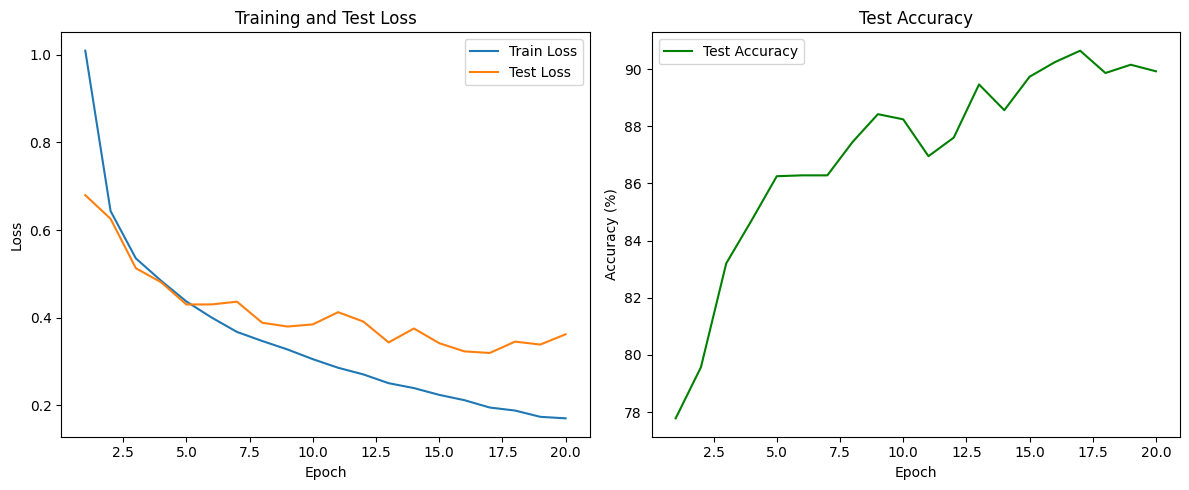

In [ ]:
# Run training and evaluation with plots
epochs = 20
train_losses, test_losses, accuracies = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)

# Plot Train and Test Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

